In [1]:
import pandas as pd
import numpy as np
import re
import random
import ast
from statistics import mode
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os, glob
import sys
import pickle
from tqdm import tqdm

plt.rcParams["font.family"] = "Times New Roman"
mpl.rcParams['figure.dpi'] = 900

import warnings
warnings.filterwarnings("ignore")

# Read in the data

In [2]:
# full_multi_task_data = pd.read_csv('all_multi_task_wave_data.txt')

In [3]:
# full_multi_task_data = full_multi_task_data.rename(columns = {"task": "task_name"})

In [4]:
# # set the score to the best score across repeated attempts, in cases where it saved multiple times
# full_multi_task_data = full_multi_task_data.groupby('stageId').apply(lambda x: x.loc[x['score'].idxmax()]).reset_index(drop=True)

In [5]:
# # task map
# task_map = pd.read_csv('task_map.csv')
# task_map = task_map.rename(columns = {"task": "task_name"})

In [6]:
# task_name_mapping = {
# 	"Sudoku": "Sudoku",
# 	"Moral Reasoning": "Moral Reasoning (Disciplinary Action Case)",
# 	"Wolf Goat Cabbage": "Wolf, goat and cabbage transfer",
# 	"Guess the Correlation": "Guessing the correlation",
# 	"Writing Story": "Writing story",
# 	"Room Assignment": "Room assignment task",
# 	"Allocating Resources": "Allocating resources to programs",
# 	"Divergent Association": "Divergent Association Task",
# 	"Word Construction": "Word construction from a subset of letters",
# 	"Whac a Mole": "Whac-A-Mole",
# 	"Random Dot Motion": "Random dot motion",
# 	"Recall Association": "Recall association",
# 	"Recall Word Lists": "Recall word lists",
# 	"Typing": "Typing game",
# 	"Unscramble Words": "Unscramble words (anagrams)",
# 	"WildCam": "Wildcam Gorongosa (Zooniverse)",
# 	"Advertisement Writing": "Advertisement writing",
# 	"Putting Food Into Categories": "Putting food into categories"
# }

# task_map = task_map.rename(
# 	columns = {
# 		"Q1concept_behav": "Conceptual-Behavioral",
# 		"Q3type_1_planning": "Type 1 (Planning)",
# 		"Q4type_2_generate": "Type 2 (Generate)",
# 		"Q6type_5_cc": "Type 5 (Cognitive Conflict)",
# 		"Q7type_7_battle": "Type 7 (Battle)",
# 		"Q8type_8_performance": "Type 8 (Performance)",
# 		"Q9divisible_unitary": "Divisible-Unitary",
# 		"Q10maximizing": "Maximizing",
# 		"Q11optimizing": "Optimizing",
# 		"Q13outcome_multip": "Outcome Multiplicity",
# 		"Q14sol_scheme_mul": "Solution Scheme Multiplicity",
# 		"Q15dec_verifiability": "Decision Verifiability",
# 		"Q16shared_knowledge": "Shared Knowledge",
# 		"Q17within_sys_sol": "Within-System Solution",
# 		"Q18ans_recog": "Answer Recognizability",
# 		"Q19time_solvability": "Time Solvability",
# 		"Q20type_3_type_4": "Type 3 and Type 4 (Objective Correctness)",
# 		"Q22confl_tradeoffs": "Conflicting Tradeoffs",
# 		"Q23ss_out_uncert": "Solution Scheme Outcome Uncertainty",
# 		"Q24eureka_question": "Eureka Question",
# 		"Q2intel_manip_1" : "Intellectual-Manipulative",
# 		"Q21intellective_judg_1" : "Intellective-Judgmental",
# 		"Q5creativity_input_1" : "Creativity Input",
# 		"Q25_type6_mixed_motive" : "Type 6 (Mixed-Motive)"
# 	}
# )

In [7]:
# full_multi_task_data.loc[:, "task_name"] = full_multi_task_data["task_name"].replace(task_name_mapping)

In [8]:
# task_cols_to_use = task_map.drop(["task_name", "Type 6 (Mixed-Motive)"], axis = 1).columns

In [9]:
# # merge the multi-task data with the task map
# full_multi_task_data = pd.merge(left = full_multi_task_data, right = task_map, on = "task_name", how = "left")

# Final Cleaned Datasets

In [10]:
# full_multi_task_data = full_multi_task_data.rename(columns = {"playerCount": "Team Size"})

In [11]:
# team_multi_task_full = full_multi_task_data[full_multi_task_data["Team Size"]>1]
# print(len(team_multi_task_full))

## Add in Composition Features

In [12]:
team_multi_task_full = pd.read_csv('../outputs/observation_level_dv_with_composition.csv')

In [13]:
players_per_stage = team_multi_task_full[["stageId", "playerIds"]]

In [14]:
players_1 = pd.read_csv('../data/players/players_wave1_epoch1.csv')
players_2 = pd.read_csv('../data/players/players_wave1_epoch2.csv')
players_wave2 = pd.read_csv('../data/players/players_wave_2.csv')
players_wave3 = pd.read_csv('../data/players/players_wave_3.csv')

players = pd.concat([players_1, players_2, players_wave2, players_wave3])
player_workerIds = players[["_id", "id"]].dropna().rename(columns = {"_id": "playerId", "id": "WorkerId"})
# parse out the first part of WorkerId
player_workerIds["WorkerId"] = player_workerIds["WorkerId"].str.split(" ").str[0]

In [15]:
# match playerIds to players_per_stage based on whether data.playerIds CONTAINS the playerId
stage_id_to_player_and_worker = pd.DataFrame(columns=["stageId", "playerId", "WorkerId"])

# Use tqdm to create a progress bar for the loop
for player in tqdm(player_workerIds["playerId"], desc="Matching playerIds"):
	stages_played = players_per_stage[players_per_stage["playerIds"].str.contains(player)].copy()

	if len(stages_played) > 0:
		# Set "playerId" column to the player's id
		stages_played["playerId"] = player
		# Get workerId of player
		workerId = player_workerIds.loc[player_workerIds["playerId"] == player, "WorkerId"].values[0]
		# Set "WorkerId" column to the player's id
		stages_played["WorkerId"] = workerId
		new_player_rows = stages_played[["stageId", "playerId", "WorkerId"]]
		stage_id_to_player_and_worker = pd.concat([stage_id_to_player_and_worker, new_player_rows], axis=0)

Matching playerIds: 100%|██████████| 2839/2839 [00:01<00:00, 1518.08it/s]


In [16]:
# heres the information we have about all the workers
panel = pd.read_csv('../data/players/individuals.csv')

In [17]:
demographics = ['birth_year', 'education_level', 'income_max', 'political_fiscal', 'political_social', 'political_party', 'gender', 'race', 'marital_status']
DEMOGRAPHIC_COLS = [col for col in panel.columns if ('IRCS' in col or 'CRT' in col or 'RME' in col or col in demographics)]

In [18]:
panel_filtered = panel[["WorkerId"] + DEMOGRAPHIC_COLS]

In [19]:
individual_workers_by_stageId = pd.merge(left = stage_id_to_player_and_worker, right = panel_filtered, on = "WorkerId", how = "left")
composition_by_stageId = individual_workers_by_stageId[["stageId"] + list(individual_workers_by_stageId.select_dtypes(include=[np.number]).columns)].groupby("stageId").mean().reset_index()

In [20]:
def consolidate_race_categories(df, column, threshold=200):
	counts = df[column].value_counts()
	to_replace = counts[counts < threshold].index
	df[column] = df[column].replace(to_replace, 'Other')
	return df

# consolidate race so that categories with less than 200 individuals becomes 'other'
individual_workers_by_stageId = consolidate_race_categories(individual_workers_by_stageId, 'race')

In [21]:
# identify cases where people put an abnormally small number for birth year; they likely put their actual age, so subtract by 2024
def transform_birth_year(df, column='birth_year'):
	condition = df[column] < 250
	df.loc[condition, column] = 2024 - df.loc[condition, column]
	return df
individual_workers_by_stageId = transform_birth_year(individual_workers_by_stageId)

In [22]:
def plot_histograms(df, columns, titles, x_label="", y_label="Number of Participants", fig_path = None):
	num_plots = len(columns)
	num_rows = (num_plots + 2) // 3
	
	fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))
	axes = axes.flatten() 
	
	colors = ["#6967A7", "#FFB862", "#D25218", "#67B7D6", "#E8A09A", "#8DD2B2"]
	
	for i, (column, title) in enumerate(zip(columns, titles)):
		ax = axes[i]
		
		if pd.api.types.is_numeric_dtype(df[column]):
			# Plot the histogram for numeric data
			ax.hist(df[column], bins=10, 
					color="#1C9E76", align='mid')
			
			# Calculate and plot mean line
			mean_value = df[column].mean()
			ax.axvline(mean_value, color='black', linestyle='dashed', linewidth=1)
		
		else:
			value_counts = df[column].value_counts()
			value_counts.plot(kind='bar', ax=ax, color=colors[:len(value_counts)])
		
		ax.set_title(title)
		ax.set_xlabel(x_label)
		ax.set_ylabel(y_label)
		ax.grid(False)
	
	for j in range(i + 1, num_rows * 3):
		fig.delaxes(axes[j])
	
	plt.tight_layout()
	if fig_path is not None:
		plt.savefig(fig_path, bbox_inches='tight')
	plt.show()

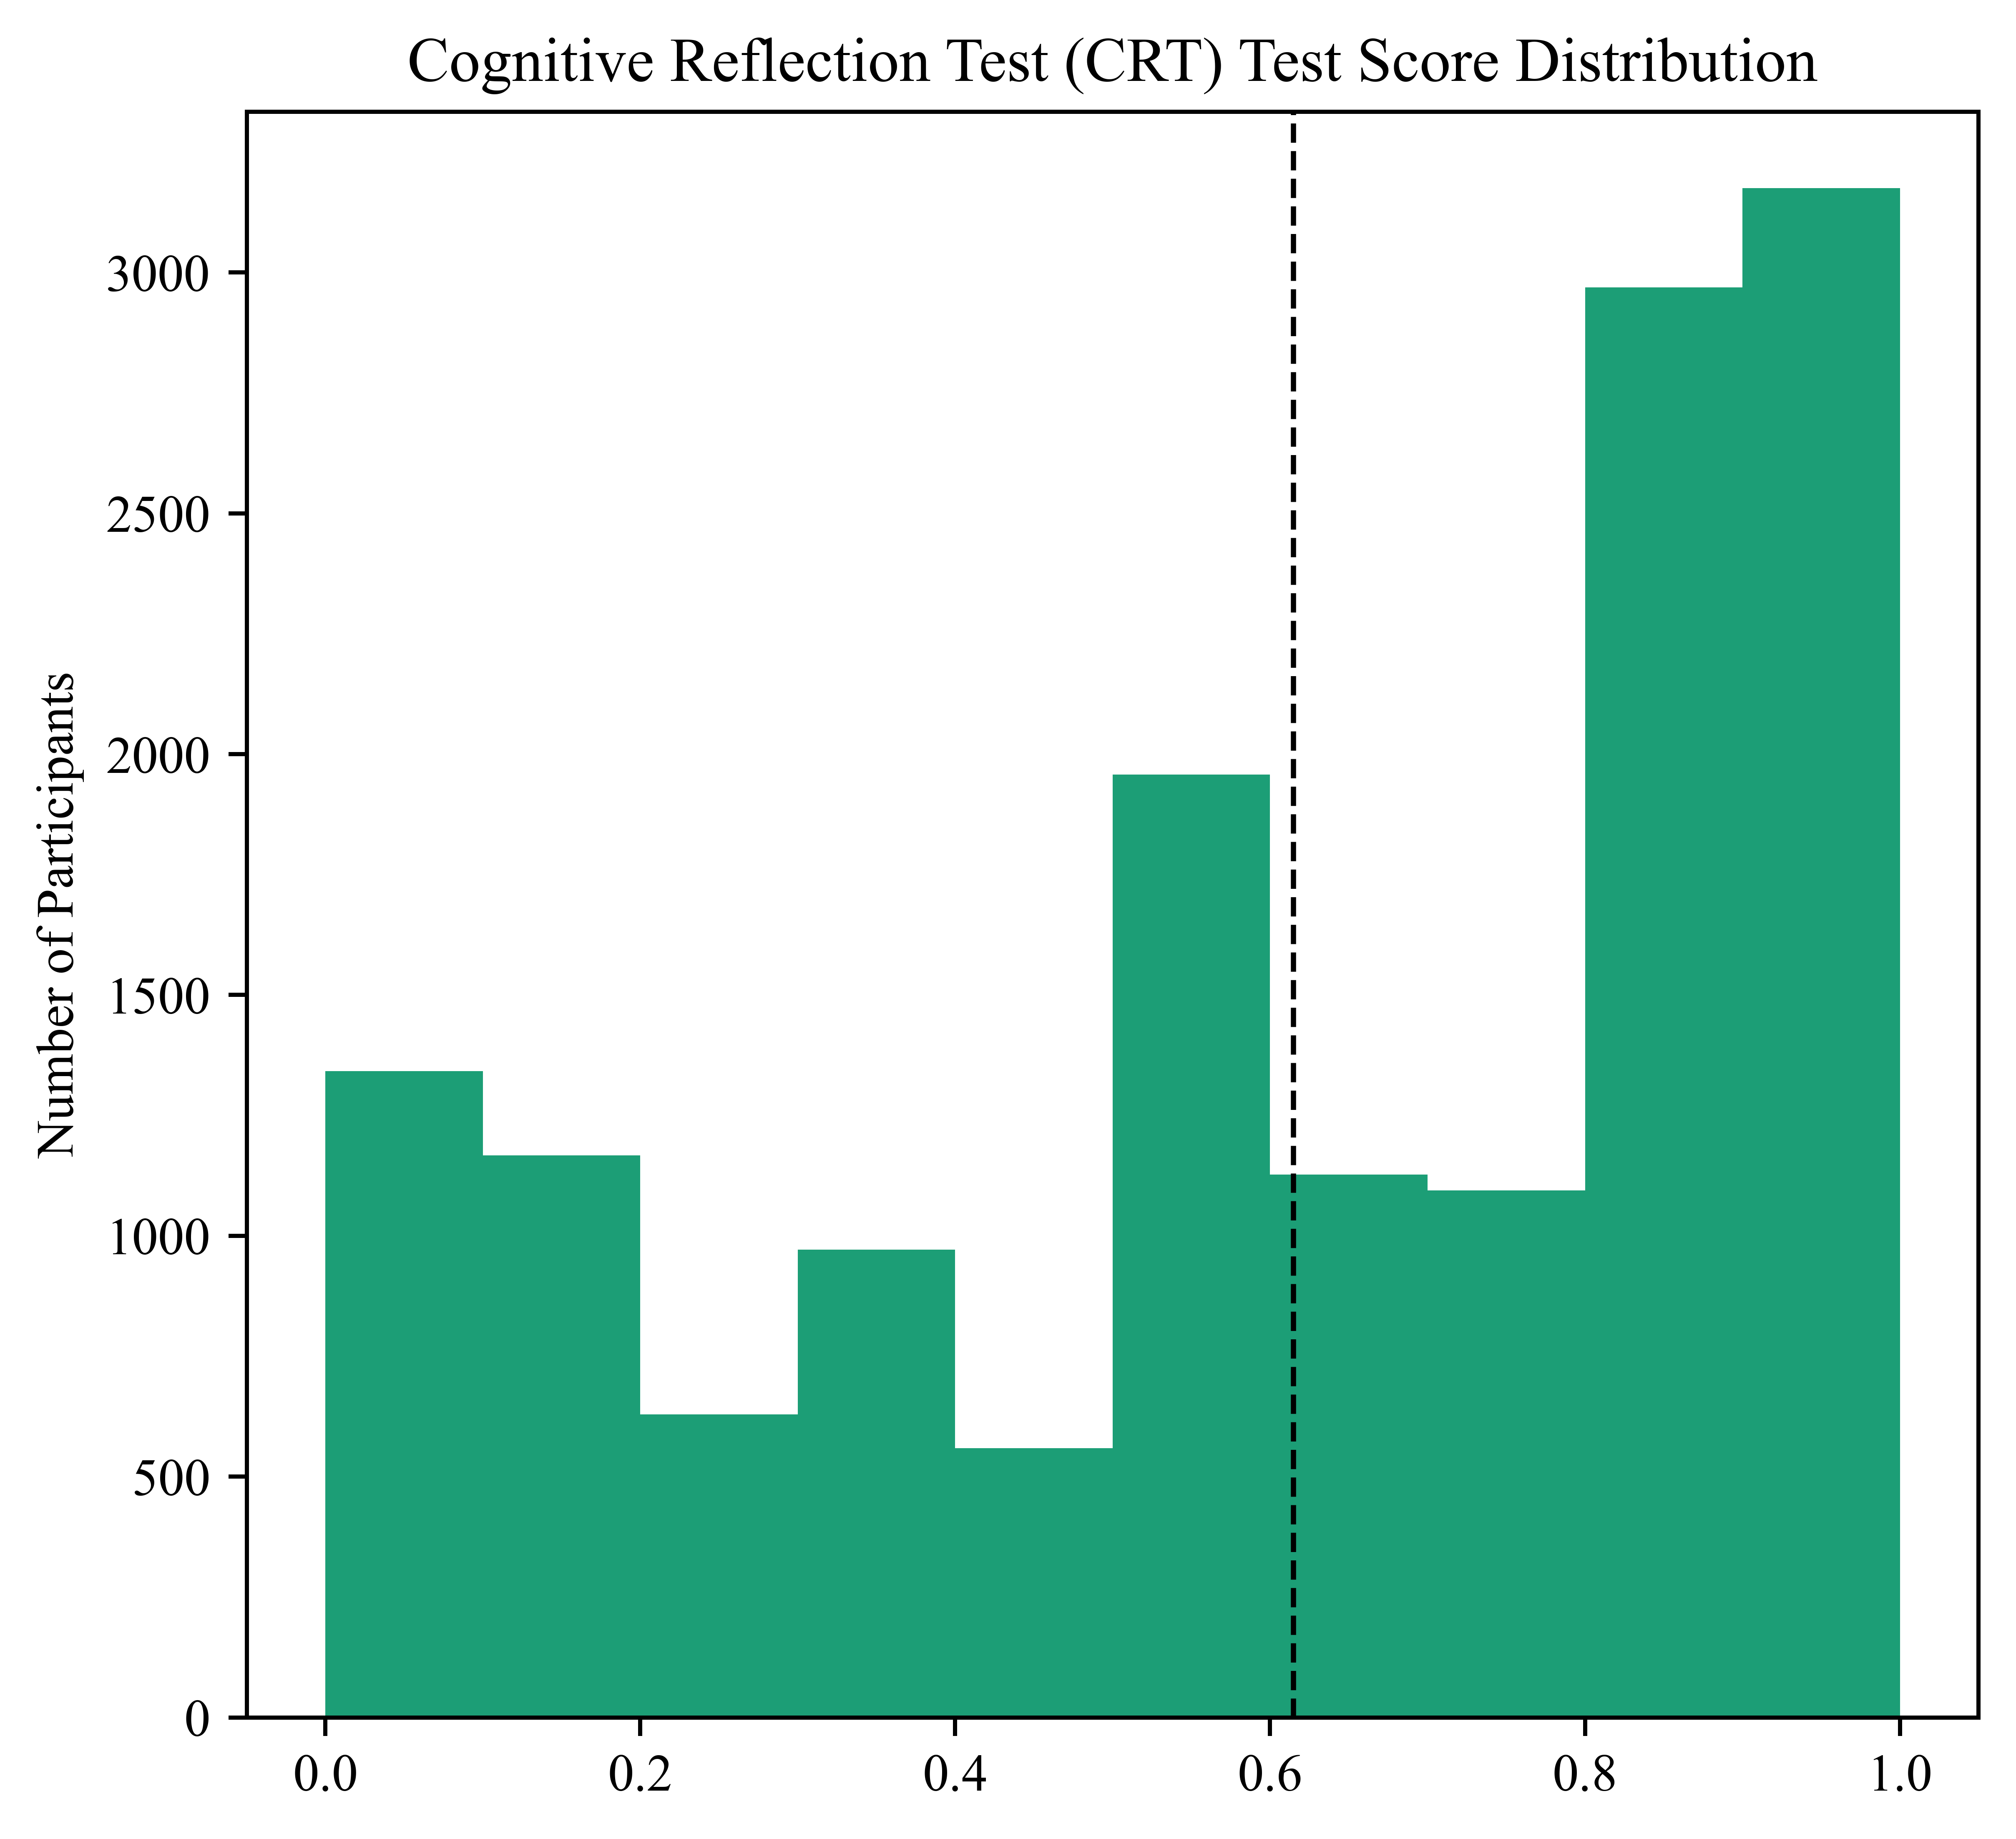

In [23]:
plot_histograms(individual_workers_by_stageId, ["CRT"], ["Cognitive Reflection Test (CRT) Test Score Distribution"], fig_path = "../outputs/crt_distribution.png")

In [24]:
individual_workers_by_stageId["CRT"].describe()

count    14991.000000
mean         0.614628
std          0.323900
min          0.000000
25%          0.333333
50%          0.666667
75%          0.857143
max          1.000000
Name: CRT, dtype: float64

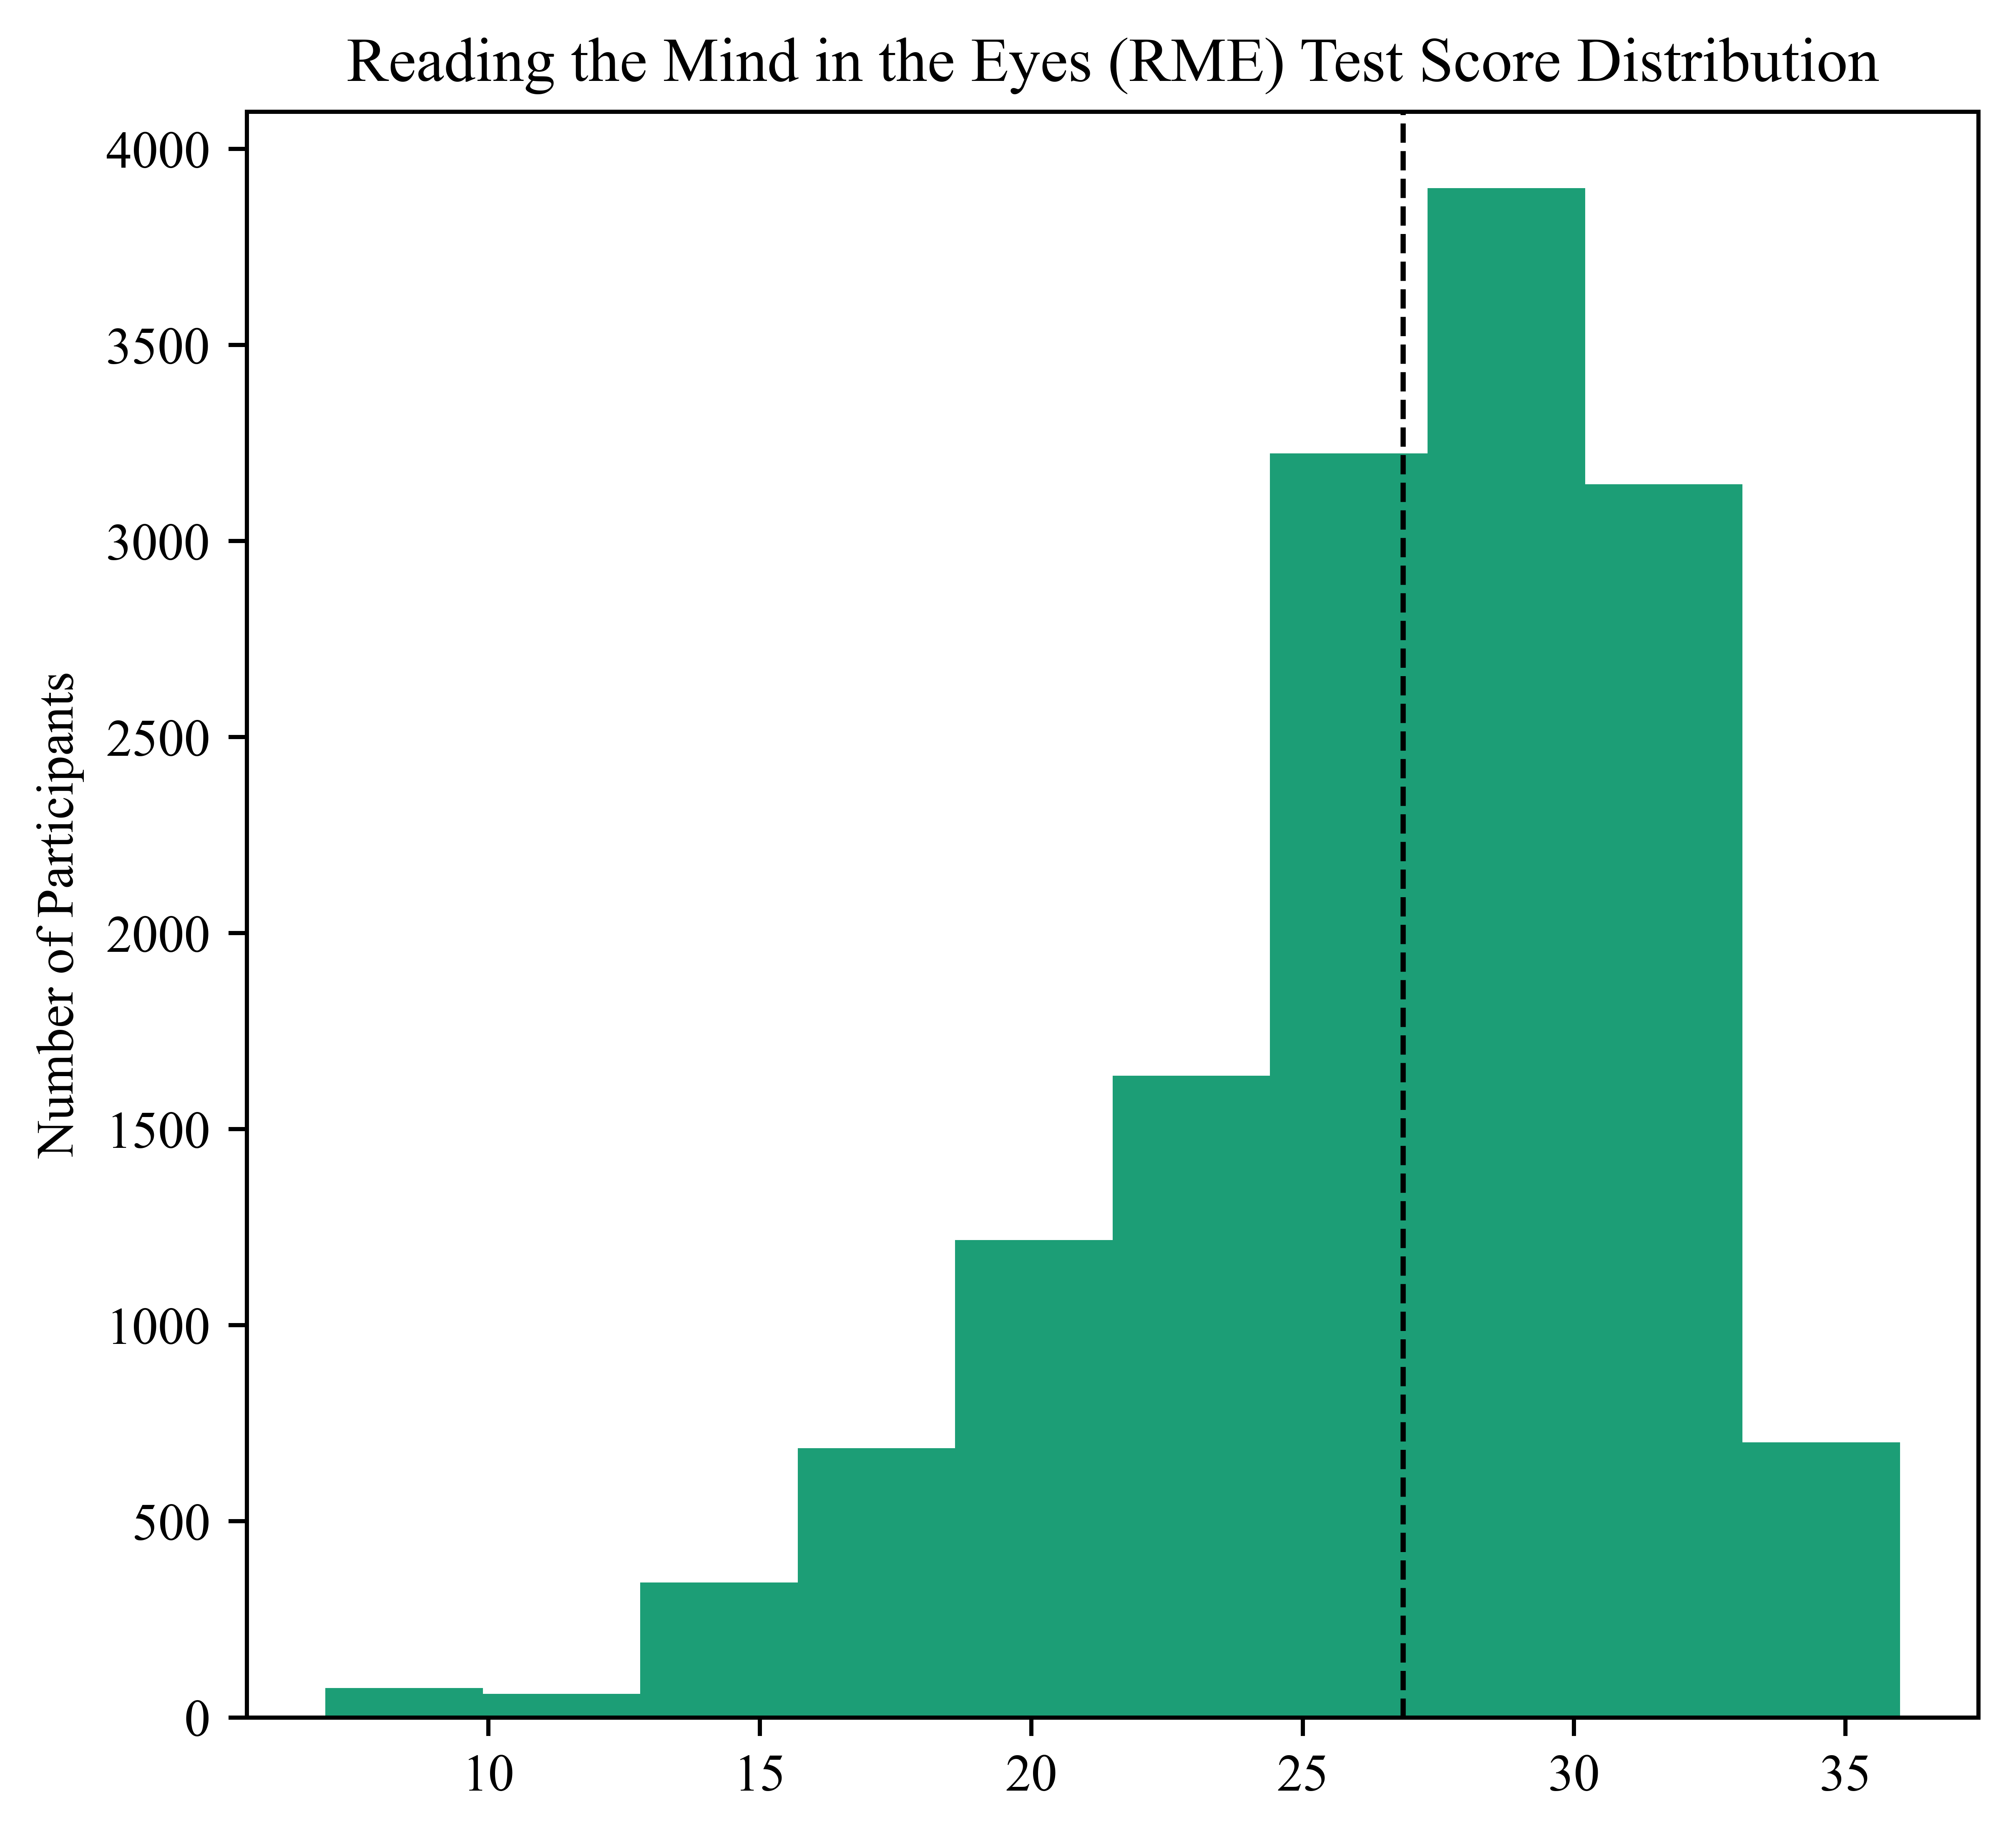

In [25]:
plot_histograms(individual_workers_by_stageId, ["RME"], ["Reading the Mind in the Eyes (RME) Test Score Distribution"], fig_path = "../outputs/rme_distribution.png")

In [26]:
individual_workers_by_stageId["RME"].describe()

count    14991.000000
mean        26.843373
std          5.092475
min          7.000000
25%         24.000000
50%         28.000000
75%         31.000000
max         36.000000
Name: RME, dtype: float64

In [27]:
ircs_cols = [col for col in DEMOGRAPHIC_COLS if "IRCS" in col]

In [28]:
ircs_name_mapping = {
	'IRCS_GS': 'Group Self (GS)',
	'IRCS_GV': 'Group Value (GV)',
	'IRCS_IB': 'Indivivdual Agency (IB)',
	'IRCS_IV': 'Individual Value (IV)',
	'IRCS_RS': 'Relational Self (RS)',
	'IRCS_IR': 'Individual Self (IS)'
}

In [29]:
plot_histograms(individual_workers_by_stageId, ircs_cols, [ircs_name_mapping[name] for name in ircs_cols], fig_path = "../outputs/ircs_distribution.png")

In [30]:
demgraphics_mapping = {
 'birth_year' : "Birth Year",
 'education_level': "Education Level",
 'income_max': "Income",
 'political_fiscal': "Political: Fiscal Views",
 'political_social': "Political: Social Views",
 'political_party': "Political: Party Affiliation",
 'gender': "Gender",
 'race': "Race",
 'marital_status': "Marital Status"
}

In [31]:
individual_workers_by_stageId[demographics].describe()

birth_year     income_max  political_fiscal  political_social
count  14991.000000   14140.000000      14991.000000      14991.000000
mean    1977.911080   64674.820934          0.553232          0.489240
std       13.036421   40809.481066          0.248368          0.246163
min     1880.000000   10000.000000          0.200000          0.166667
25%     1970.000000   29999.000000          0.400000          0.200000
50%     1980.000000   49999.000000          0.600000          0.400000
75%     1987.000000   99999.000000          0.800000          0.600000
max     2023.000000  149999.000000          1.000000          1.000000

In [32]:
individual_workers_by_stageId["gender"].value_counts()["Male"]/individual_workers_by_stageId["gender"].value_counts().sum()

0.5517310386231739

In [33]:
individual_workers_by_stageId["gender"].value_counts()["Female"]/individual_workers_by_stageId["gender"].value_counts().sum()

0.44026415849509704

In [34]:
individual_workers_by_stageId["race"].value_counts()["White"]/individual_workers_by_stageId["race"].value_counts().sum()

0.7239313912333243

In [35]:
plot_histograms(individual_workers_by_stageId, demographics, [demgraphics_mapping[name] for name in demographics], fig_path = "../outputs/demographics_distribution.png")